In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Tuple
from scipy.special import softmax

#Adjusting matplotlib settings:

matplotlib.rcParams.update({'font.size':25})
matplotlib.rcParams['axes.prop_cycle']= \
matplotlib.cycler(color=['darkblue', 'cornflowerblue', 'dodgerblue',\
                         'seagreen', 'mediumseagreen', 'forestgreen',\
                         'goldenrod','darkorange', 'peru', 'orangered',\
                         'indianred'])

In [2]:
class Bandit:
    
    def __init__(self, numArms, armProbs, armRewards):
        
        self.numArms = numArms
        self.armProbs = armProbs
        self.armRewards = armRewards
        self.qValues = np.zeros(self.numArms)
        
        
    @classmethod
    def zeroRewards(bandit, numArms, armProbs):
        return bandit(numArms, armProbs, np.zeros(numArms))
    
    @classmethod
    def zeroProbs(bandit, numArms, armRewards):
        return bandit(numArms, np.zeros(numArms), armRewards)
    
    @classmethod
    def defaultBandit(bandit, numArms):
        return bandit(numArms, np.zeros(numArms), np.zeros(numArms))
    
    #Getter/Setter methods

    def get_numArms(self):
        return self.numArms
    
    def set_numArms(self, numArms):
        self.numArms = numArms
        
    def get_armProbs(self):
        return self.armProbs
    
    def set_armProbs(self, armProbs):
        self.armProbs = armProbs
        
    def get_armRewards(self):
        return self.armRewards
    
    def set_armRewards(self, armRewards):
        self.armRewards = armRewards
        
    def get_qValues(self):
        return self.qValues
        
    def set_qValues(self, qValues):
        self.qValues = qValues
        
    
    #Part 2: 
        
    def generate_reward(self, leverNums: np.ndarray):
        
        '''
        Performs a single turn of all the bandits and increments
        the received reward, where rewards are dispense by the bandits
        @params:
        leverNums: the levers/lever to be pressed
        '''
        
        
        result = np.zeros(self.numArms)
        randNums = np.ones(self.numArms)
        #Fill randNums for pulled levers:
        for lever in leverNums:
            randNums[lever] = np.random.uniform()
            
        #Increment results where randNums < armProbs
        result[np.where(randNums[:-1] < self.armProbs[:-1])] += 1
          
        return result 
    
    def generate_reward_mod(self, leverNums: np.ndarray):
        '''
        Modiefied version of reward generation wherein the last
        lever constitutes a 'trap'. The agent is punished for 
        performing this action
        @params: same as above
        '''
        
        result = np.zeros(self.numArms)
        randNums = np.ones(self.numArms)
        
        for lever in leverNums:
            randNums[lever] = np.random.uniform()
        
        result[np.where(randNums[:-1] < self.armProbs[:-1])] += 1
        result[-1] -= 5000 if randNums[-1] < self.armProbs[-1] else 0
        
        return result
    
    
    def perform_iterations(self, numIters):
        
        for index in range(numIters):
            
            self.armRewards += self.generate_reward(np.arange(self.numArms))
            
        return self.armRewards
    
    #Part 4:
    
    def eps_greedy(self, eps):
        
        #Press lever with highest Q-Value with probability 1-eps:
        
        leverNums = np.where(self.qValues==self.qValues.max())
        randNum = np.random.uniform()
        maxQ = self.qValues.max()
        
        if randNum <= 1-eps:
            leverNums = np.where(self.qValues==maxQ)[0] #exploit 
        
        else:
            leverNums = np.array([np.random.choice(self.numArms)])#explore
            
            
        leverQ = self.qValues[np.random.choice(leverNums)] #Q-value of pressed levers

        return leverNums, leverQ, maxQ
    
    def eps_greedy_run(self, 
                       eps: float, 
                       total_pulls: int,
                       eta: float = .01,
                       mod: bool=False):
        '''
        Runs the eps greedy policy.
        @params:
        eps: basically - how greedy is the agent?
        total_pulls: number of overall actions
        eta: learning rate
        mod: use modified generate_reward function?
        @return:
        armsQ: qValue of operated arm(s) (action)
        bestPickedQ: Picked best action?
        maxQs: highest qValues
        '''
        
        #Remembers whether best action picked or not
        bestQPicked = np.zeros(total_pulls)
        armsQ = np.zeros(total_pulls) #Stores qValues of all ten arms:
        maxQs = np.zeros(total_pulls) #Stores maxQ on all armpulls
        
        i = 0
        while i < total_pulls:
            
            leversPulled, leverQ, maxQ = self.eps_greedy(eps)
            
            if maxQ==leverQ:
                bestQPicked[i] = True
                
            else:
                bestQPicked[i] = False
                
            #Generate reward from pulled levers:
            if mod:
                rewards = self.generate_reward_mod(leversPulled)
            else:
                rewards = self.generate_reward(leversPulled)
                
            #Apply learning rule:
            deltaQ = eta*(rewards - self.qValues)
            self.qValues += deltaQ 
            armsQ[i:i+len(leversPulled)] = self.qValues[leversPulled]
            maxQs[i:i+len(leversPulled)] = np.ones(len(leversPulled))*maxQ
            
            i += len(leversPulled)
            
        return armsQ, bestQPicked, maxQs
    
    def softmax(self, 
                beta: float, 
                total_pulls: int=5000, 
                eta: float=.01,
                mod: bool=False,
                beta_mod: bool=False,
                b=None):
        
        '''
        Picks actions according to the softmax policy:
        @params:
        beta: a parameter that dictates exploration/exploitation trade-off
        mod: modify so that last action is trap
        beta_mod: modify so that beta cools down over iterations
        b: parameter that determines the slope of the cooldown
        @return: an action to perform

        '''
        maxQ = np.zeros(total_pulls) #stores maximum Q
        leverQ = np.zeros(total_pulls) #stores Q of current lever
        cumReward = np.zeros(total_pulls) #cumulative reward
        
        
        for i in range(total_pulls):
            
            if beta_mod:
                beta2 = 1 + i/b
                
            else:
                beta2 = beta
                

            #Get arm probabilities:
            armProbs = softmax(beta2*self.qValues)
            
            #Select a lever to pull:
            lever = np.random.choice(range(self.numArms), p=armProbs)
            
            if mod:
                rewards = self.generate_reward_mod([lever])
            else:
                rewards = self.generate_reward([lever])
                
            #Apply learning rule:
            deltaQ = eta*(rewards - self.qValues)
            self.qValues += deltaQ
            
            maxQ[i] = self.qValues.max()
            leverQ[i] = self.qValues[lever]
            
            if i==0:
                cumReward[i] = rewards.sum()
            else:
                cumReward[i] = cumReward[i-1] + rewards.sum()
                
            
        return maxQ, leverQ, cumReward


$\textbf{Part 2:}$

In [3]:
#Initialize 10-armed Bandits object:
nautilus = Bandit.defaultBandit(10) #small decapod-related joke
nautilus.set_armProbs(np.random.uniform(0,1,nautilus.get_numArms()))

#Perform 10000 runs of generate_reward function:

print('The mean reward over 1000 iterations is: ')
print(nautilus.perform_iterations(10000) / 10000)

print('The reward probabilities are: ')
print(nautilus.armProbs)

#Resetting rewards to zero:
nautilus.set_armRewards(np.zeros(nautilus.numArms))

The mean reward over 1000 iterations is: 
[0.5637 0.8482 0.2619 0.3089 0.1068 0.3043 0.2835 0.8202 0.657  0.    ]
The reward probabilities are: 
[0.56075865 0.8504008  0.26545885 0.30787616 0.10241555 0.3076324
 0.28831854 0.82209378 0.65570879 0.74434515]


The means and the probabilities are nearly identical. Knowing the law of large numbers this is what we should have excpected.

$\textbf{Part 5+6:}$

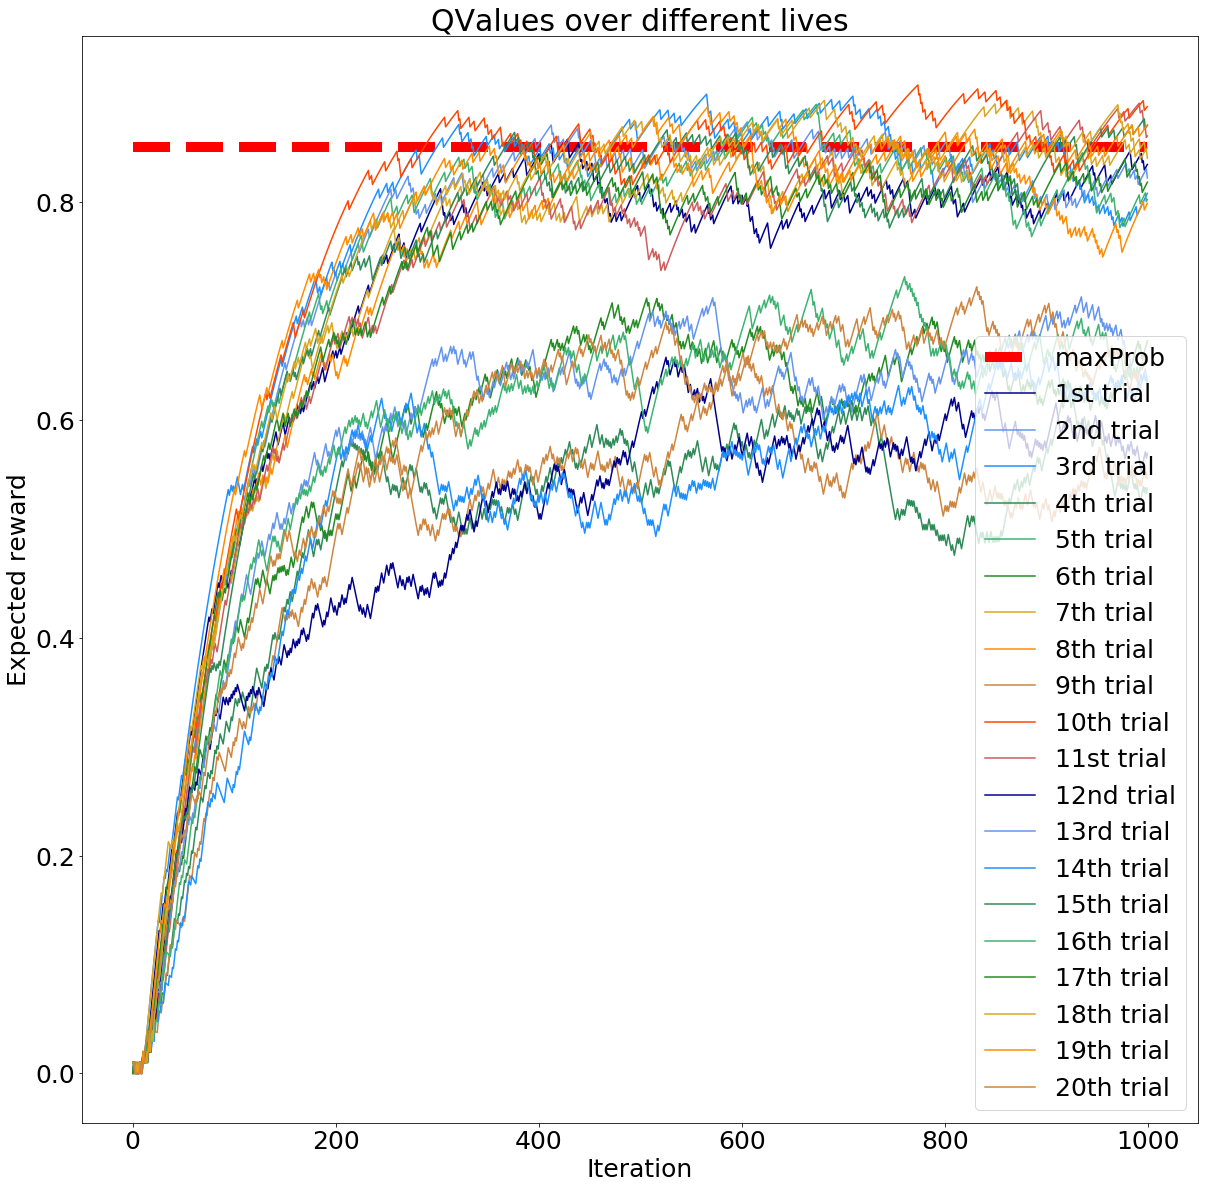

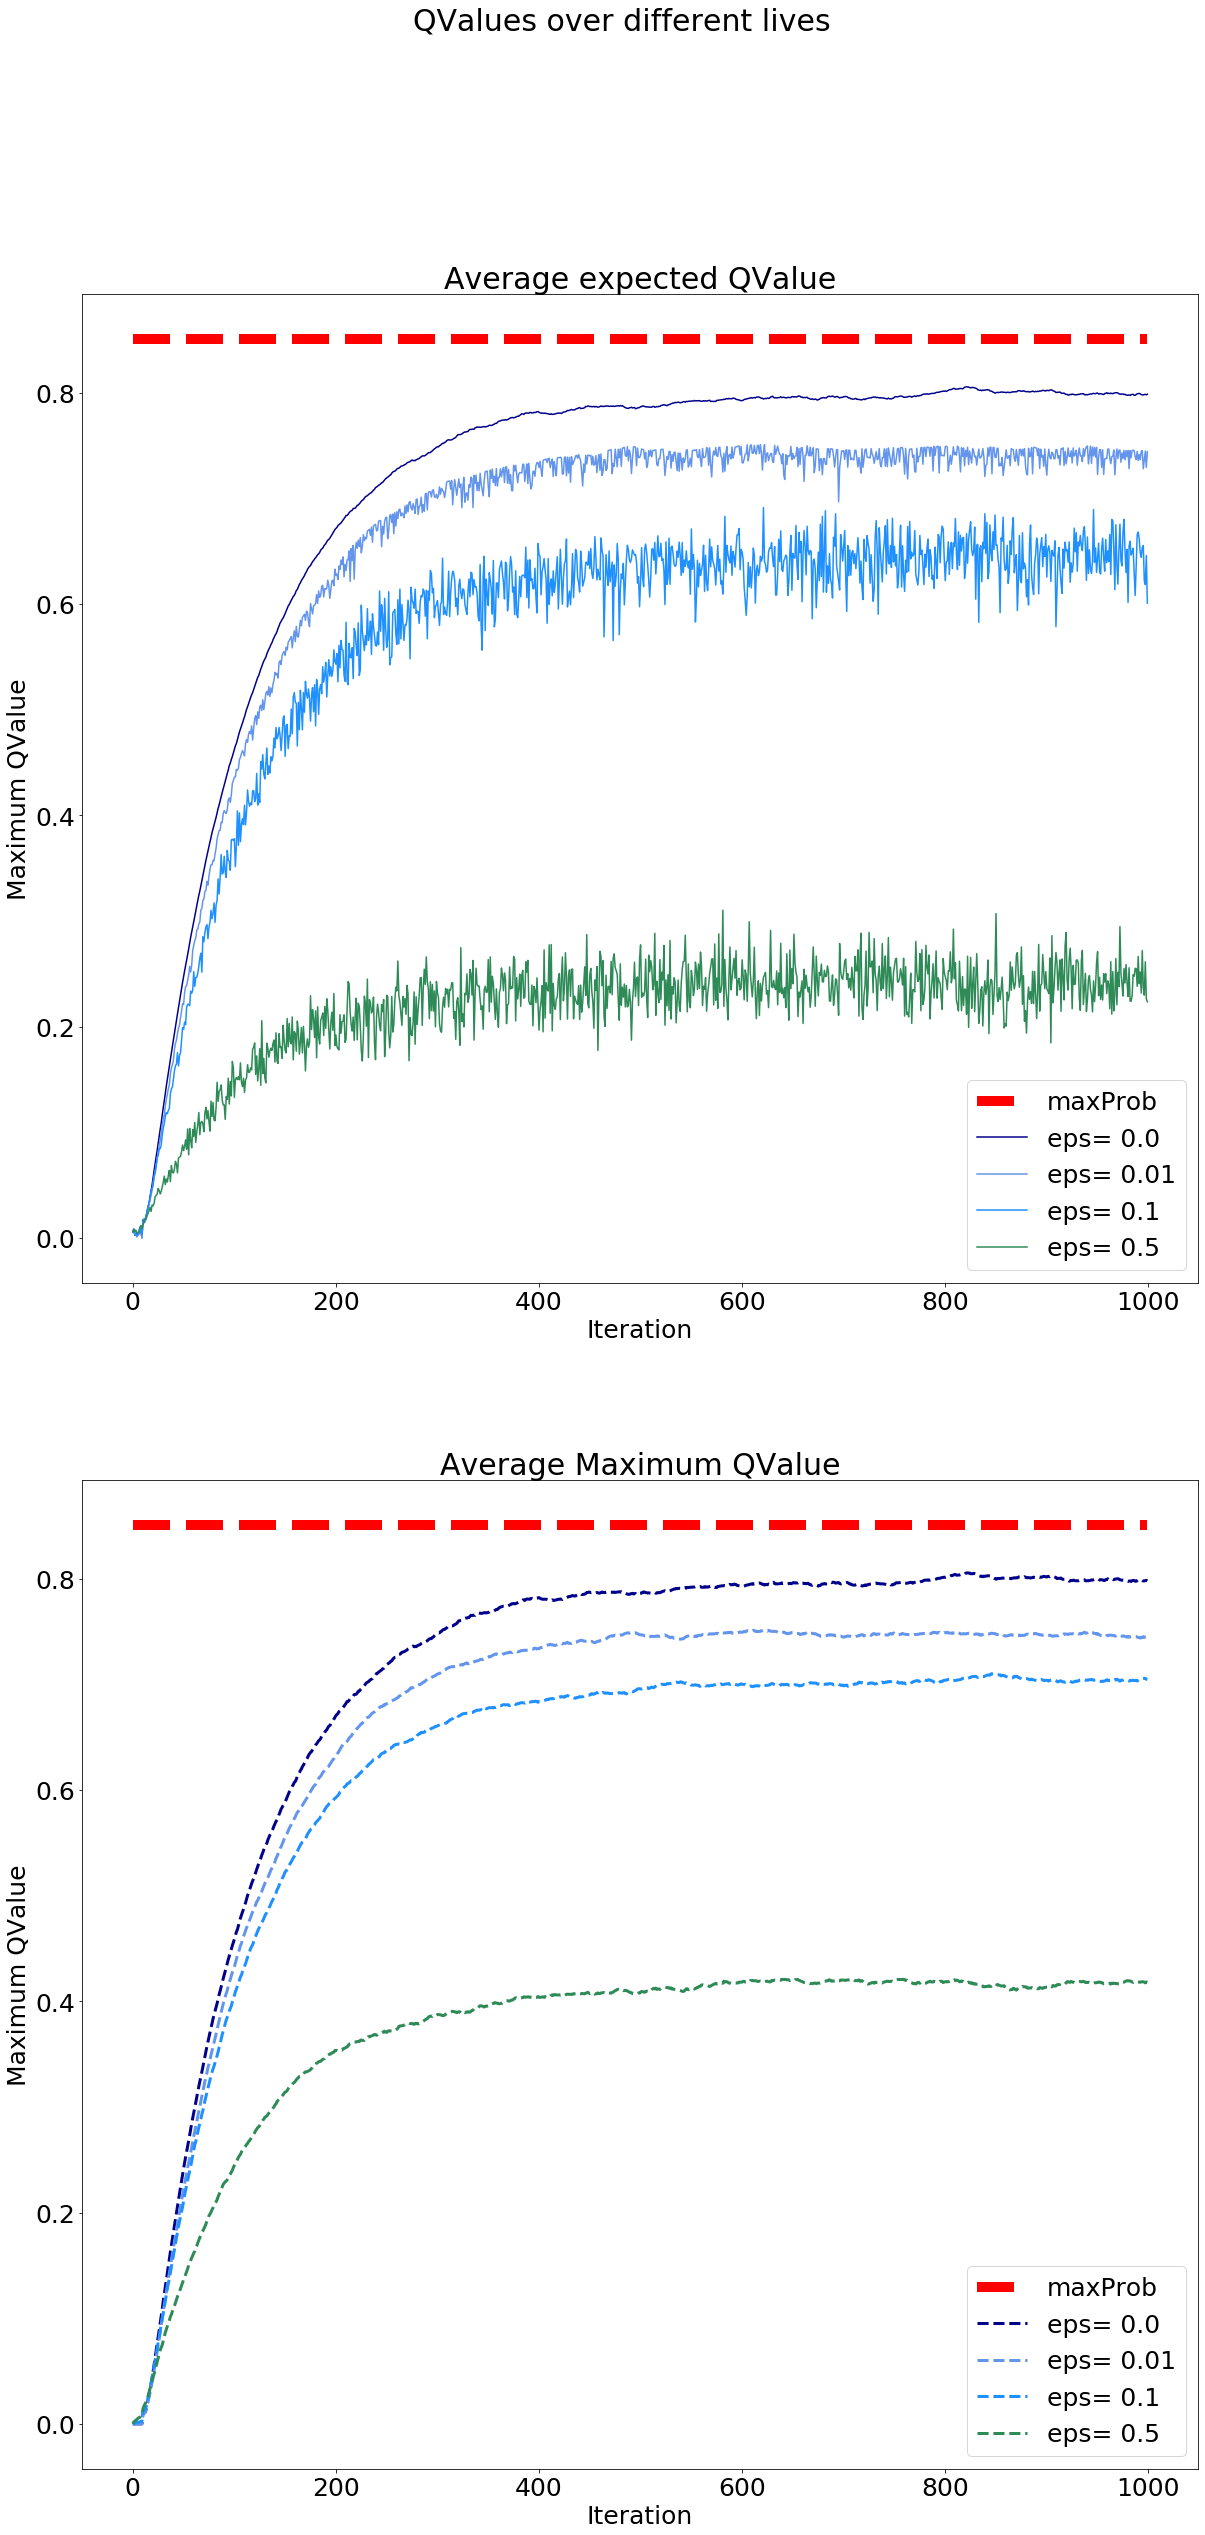

In [4]:
#Get ordinals for pretty printing:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])

def plot_qVals(lives: Tuple[int]=(20,100), iters: int=1000) -> None:
    
    lives5, lives6 = lives
    
    #Part 5:
    
    plt.figure(figsize=(20,20))
    ax1 = plt.gca()
    plt.title('QValues over different lives')
    plt.ylabel('Expected reward')
    plt.xlabel('Iteration')
    plt.plot(np.repeat(nautilus.armProbs.max(), iters), '--r', linewidth=10,\
            label='maxProb')
    
    result = np.zeros((lives5, iters))
    bestQPicked = np.zeros(lives5)
    
    for i in range(lives5):
        
        res = nautilus.eps_greedy_run(0.0,iters)
        result[i,:] = res[0]
        bestQPicked[i] = np.all(res[1]) #allways picked best action?
        nautilus.set_armRewards(np.zeros(nautilus.numArms))
        nautilus.set_qValues(np.zeros(nautilus.numArms))
        plt.plot(result[i,:], label= ordinal(i+1)+' trial')
    
    plt.legend()
    plt.show()
    

    #Part 6:
    epss = [.0,.01,.1,.5]
    
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,40))
    plt.suptitle('QValues over different lives')
    
    ax1.set_title('Average expected QValue')
    ax1.set_ylabel('Maximum QValue')
    ax1.set_xlabel('Iteration')
    ax1.plot(np.repeat(nautilus.armProbs.max(), iters), '--r', linewidth=10,\
             label='maxProb')
    
    ax2.set_title('Average Maximum QValue')
    ax2.set_ylabel('Maximum QValue')
    ax2.set_xlabel('Iteration')
    ax2.plot(np.repeat(nautilus.armProbs.max(), iters), '--r', linewidth=10,\
             label='maxProb')
    
    avgs = np.zeros((len(epss), iters))
    avgsMax = np.zeros((len(epss), iters))
    
    for epsI, eps in enumerate(epss):
        
        result = np.zeros((lives6, iters))
        maxResult = np.zeros((lives6, iters))
        
        for i in range(lives6):
            
            res = nautilus.eps_greedy_run(eps,iters)
            result[i,:] = res[0]
            maxResult[i,:] = res[2] 
            nautilus.set_armRewards(np.zeros(nautilus.numArms))
            nautilus.set_qValues(np.zeros(nautilus.numArms))
        
        avgs[epsI,:] = result.mean(axis=0)#average of expected reward
        avgsMax[epsI,:] = maxResult.mean(axis=0)#average of maxQ
        ax1.plot(avgs[epsI,:], label='eps= {}'.format(eps))
        ax2.plot(avgsMax[epsI,:], '--', linewidth = 3, label='eps= {}'.format(eps))
        
        
    
    ax1.legend()
    ax2.legend()
    plt.show()
        
    return None

plot_qVals()

The theoretical QValue for the actions should be their probabilites. In this case most curves should tend against the highest reward probability, which is $\approx$ .85% (obsolete if you run again). This is confirmed by the curves.

$\textbf{A couple of observations:}$ $bestQ$ collects whether we heave always chosen the lever with the highest QValue on every trial. Since, its entries are all true (for $eps = 0$), we can surmise that the agent actually picks the action with the best qValue (at that time). However, on some occassions, the agent will pick an action that doesn't have the highest reward probability, because the corresponding lever didn't dispense a reward previously and some other action has (momentarily) a higher QValue. How many curves approach the limit within the bound of a 1000 pulls is a function of what the largest reward probability is. With a reward probability of 97% all curves attained the limit, with a maximum reward probability of 67% only very few did. This is because, at large maximum reward probabilities, the lever with that probability reliably dispenses that reward, so it's bound to be picked on every iteration. Additionally, this is also a function of $\textbf{how many}$ levers have high reward probabilities. If all ten levers have high probabilities, then they'll, on average, each dispense a reward on every iteration (which is why they are likely to have the same Qvalue and all be selected together again on the next iteration, which absorbs a lot of pulls). Consequently, the 1000 pulls will be equally distributed across levers and the Q-Values cannot reach their theoretical limit within the bound of a thousand pulls.

The curves in the lower figures look as they do, because, as we increase $\epsilon$ the agent tends to explore more. This has two consequences: first of all, there is more noise in the curves, since the agent will more often tend to perform actions with low Q-values. The noise grows with $\epsilon$ because, when $\epsilon$ is small, the noise is averaged out over lives, since the agent, in the overwhelming majority of cases, will perform the action it thinks to be best. And secondly, the Q-Values will 'top-out' below the maximum probabilities. Given more time, the individual QValues wouls still tend toward the actual probabilities (this is the theoretical result), but not within a reasonable time-bound.

$\textbf{Part 7:}$

In [5]:
#Resetting rewards/qValues to zero:
nautilus.set_armRewards(np.zeros(nautilus.numArms))
nautilus.set_qValues(np.zeros(nautilus.numArms))

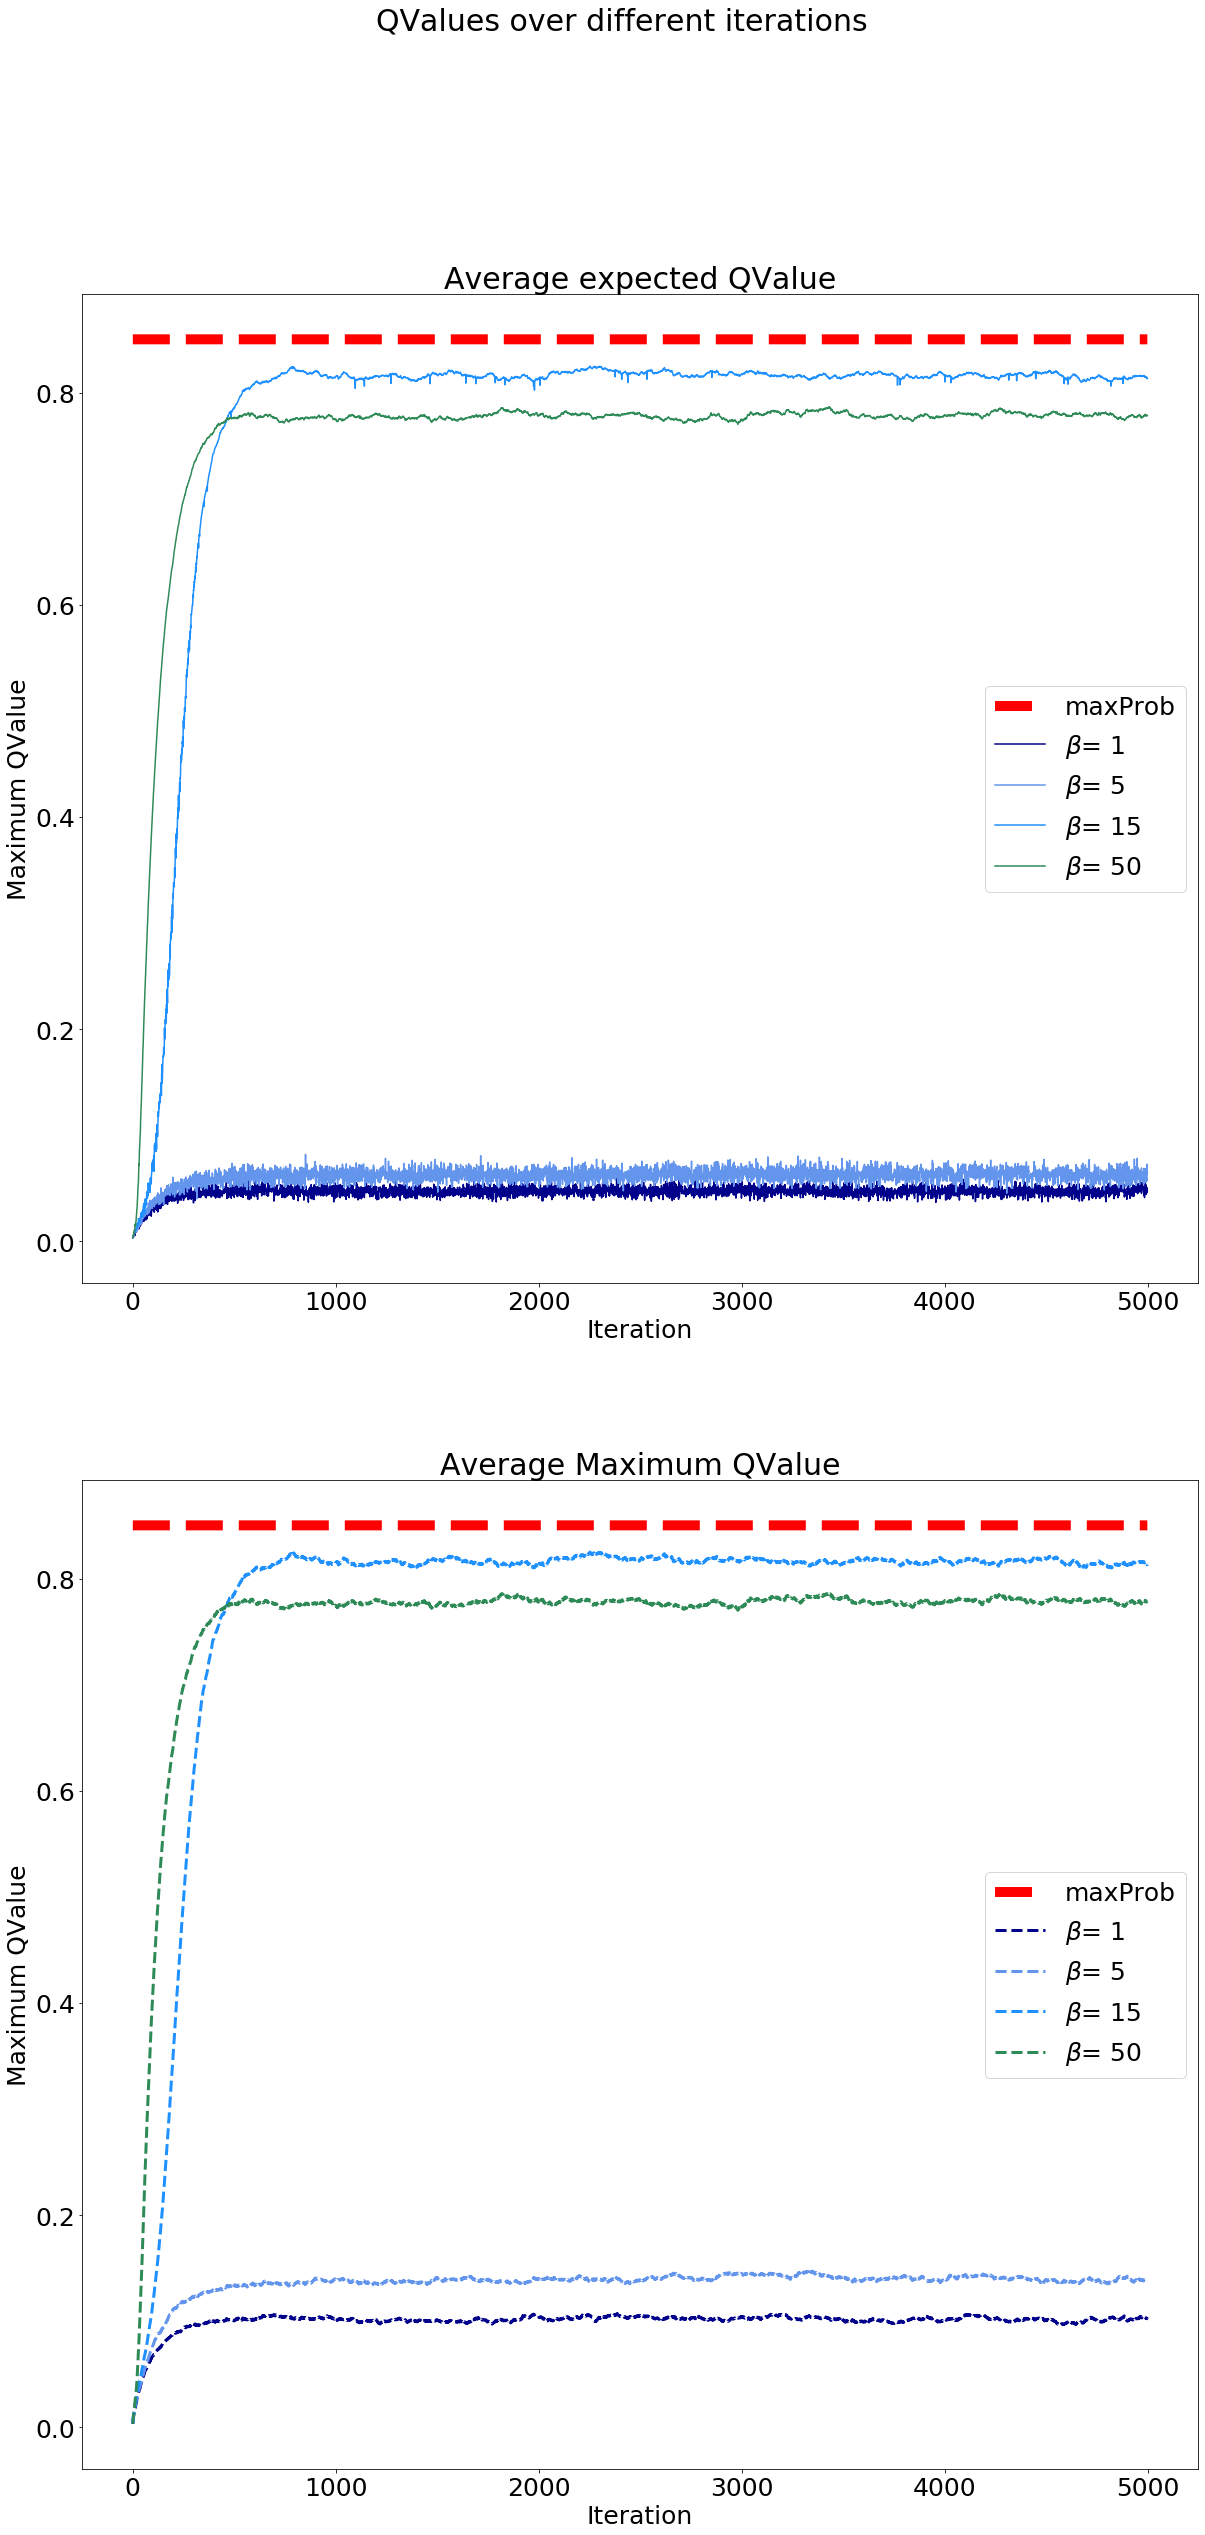

In [6]:
def plot_softmax(lives: int=100, total_pulls: int=5000) -> None:
    
    betas = [1,5,15,50]
    
    avgs = np.zeros((len(betas), total_pulls))
    avgsMax = np.zeros((len(betas), total_pulls))
    
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,40))
    plt.suptitle('QValues over different iterations')
    
    ax1.set_title('Average expected QValue')
    ax1.set_ylabel('Maximum QValue')
    ax1.set_xlabel('Iteration')
    ax1.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    ax2.set_title('Average Maximum QValue')
    ax2.set_ylabel('Maximum QValue')
    ax2.set_xlabel('Iteration')
    ax2.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    for betaI, beta in enumerate(betas):
        
        maxQs = np.zeros((lives, total_pulls))
        leverQs = np.zeros((lives, total_pulls))
        
        for life in range(lives):
        
            res = nautilus.softmax(beta, total_pulls)
            maxQs[life,:] = res[0]
            leverQs[life,:] = res[1]
            #Resetting rewards/qValues to zero:
            nautilus.set_armRewards(np.zeros(nautilus.numArms))
            nautilus.set_qValues(np.zeros(nautilus.numArms))
            
        avgs[betaI,:] = leverQs.mean(axis=0)
        avgsMax[betaI,:] = maxQs.mean(axis=0)
        ax1.plot(avgs[betaI,:], label=r'$\beta$= {}'.format(beta))
        ax2.plot(avgsMax[betaI,:], '--', linewidth = 3, label=r'$\beta$= {}'.format(beta))
    
    ax1.legend()
    ax2.legend()
    plt.show()
        
    
    return None

plot_softmax()

$\textbf{Observation:}$ The plots clearly show how $\beta$ affects the exploration exploitation trade-off. For low $\beta$ the agent explores a lot. The curves remain close to the bottom, because the agent often chooses actions that do not result in rewards (resulting in negative $\Delta$Qs. For high $\beta$, on the other hand, quickly approach the theoretical maximum, since the agent exploits more, picking the action with the highest QValue almost every round.

$\textbf{Part 8: Test both policies on 'trap'-agent:}$

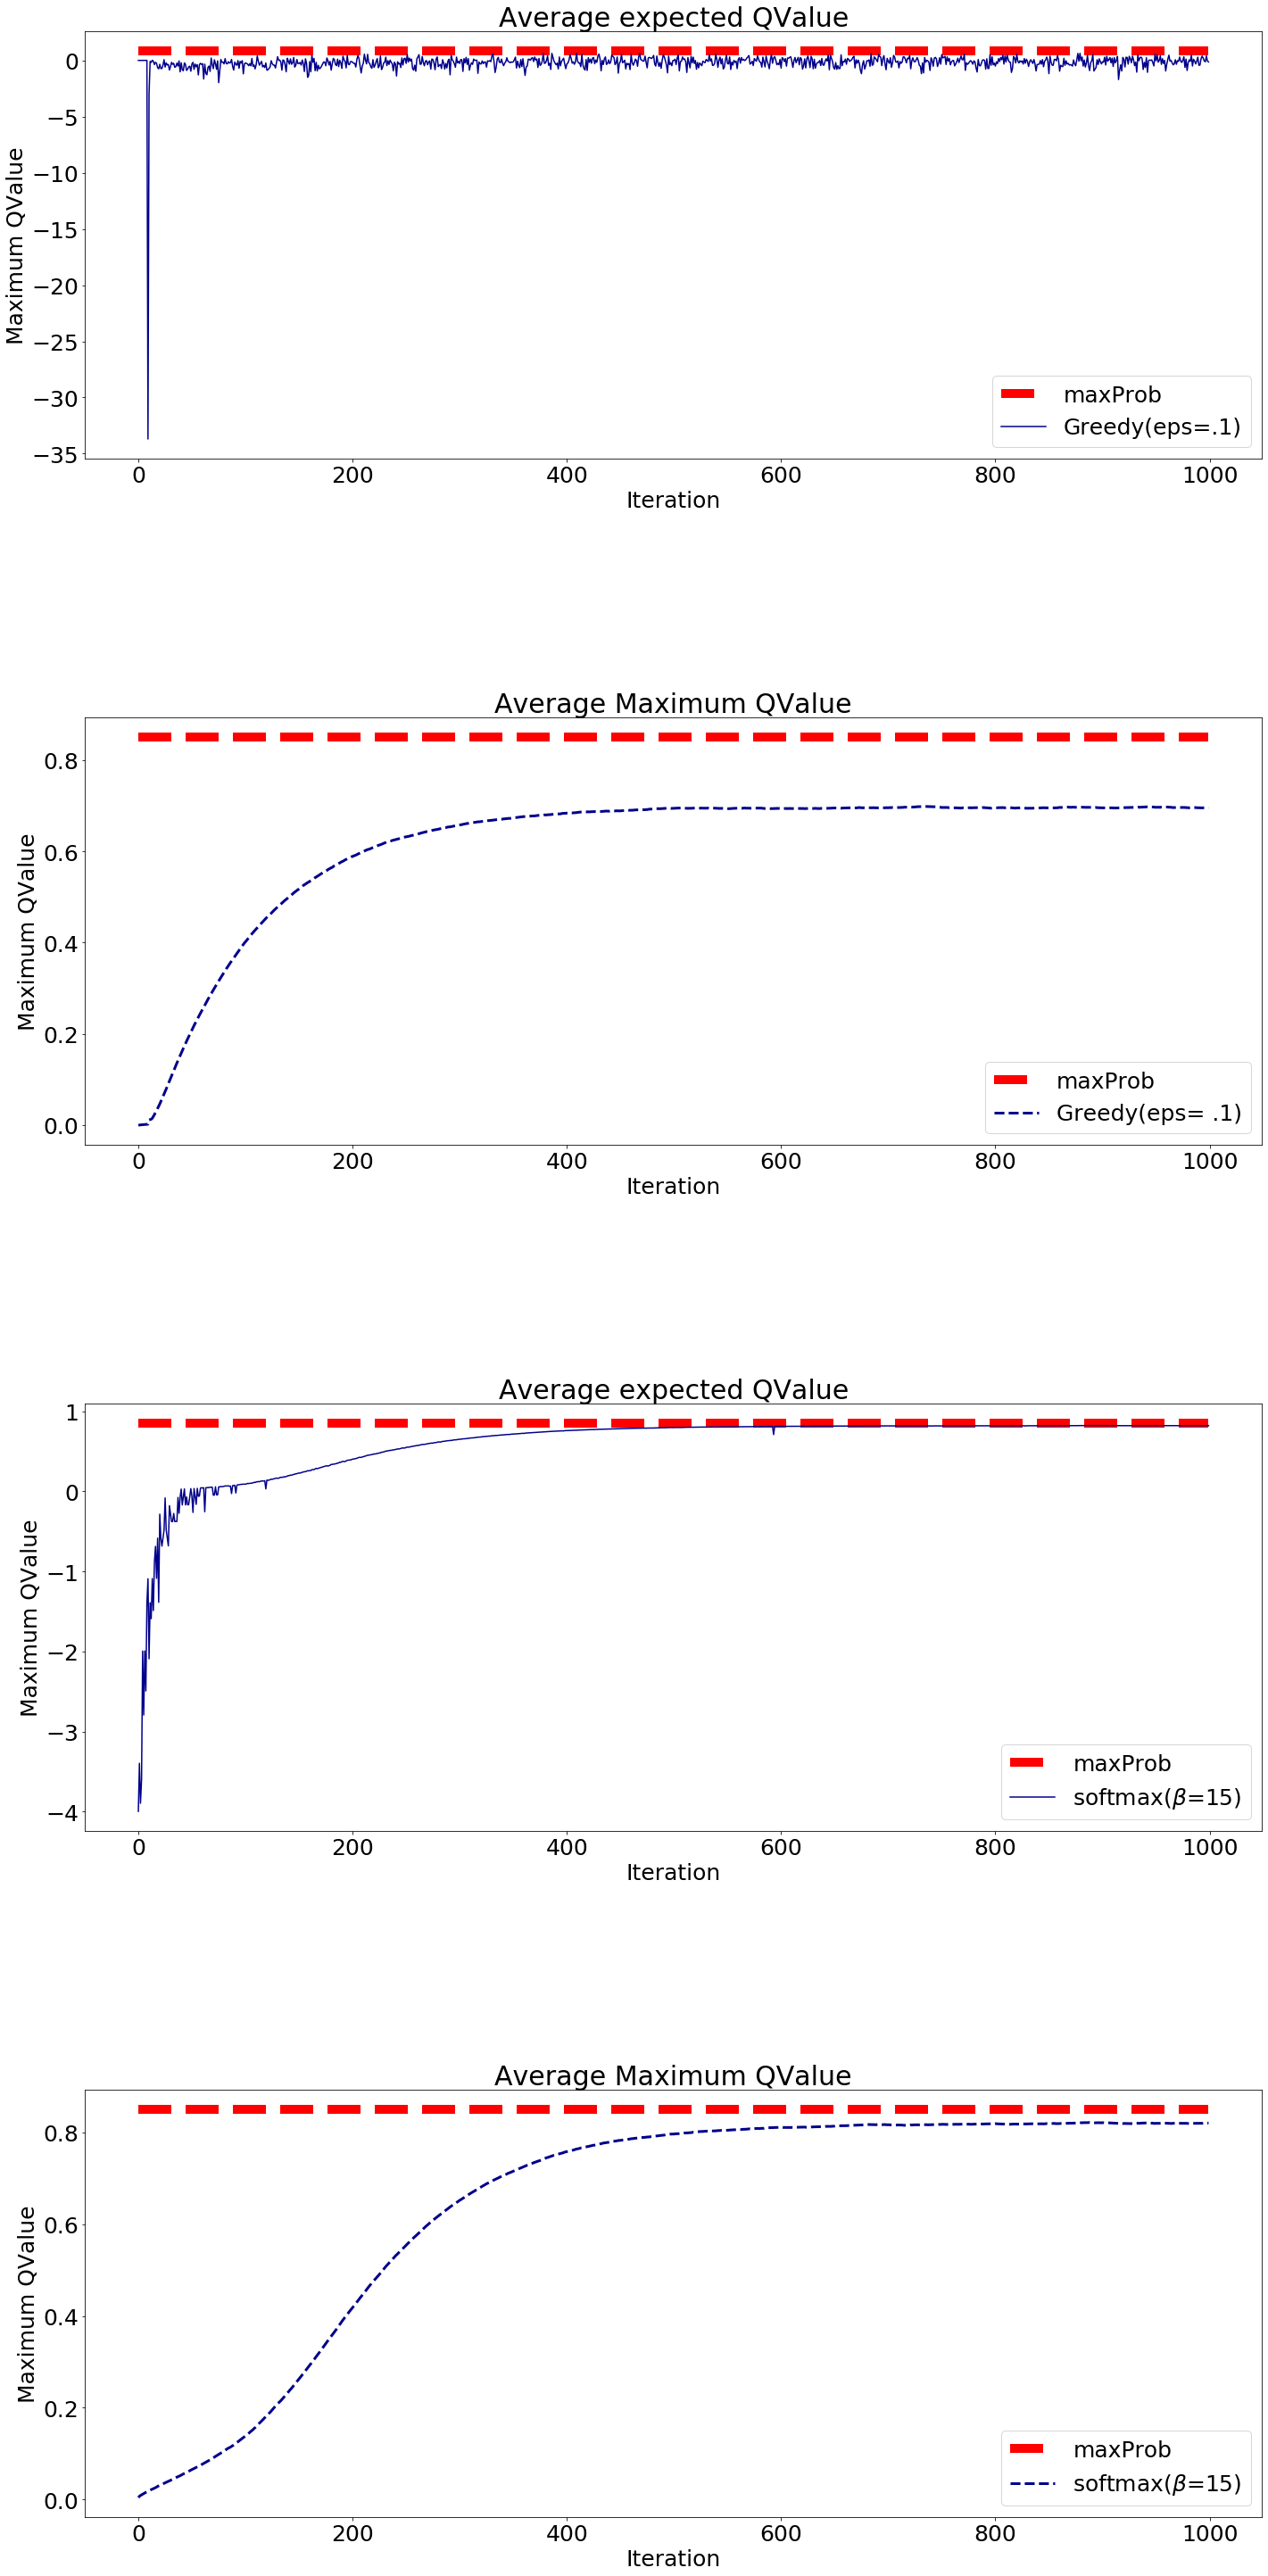

In [7]:
def plot_trap_agent(lives: int=500, total_pulls: int=1000) -> None:
    
    #Greedy policy:
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,40))
    plt.tight_layout(h_pad=10, w_pad=10)
    
    ax1.set_title('Average expected QValue')
    ax1.set_ylabel('Maximum QValue')
    ax1.set_xlabel('Iteration')
    ax1.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    ax2.set_title('Average Maximum QValue')
    ax2.set_ylabel('Maximum QValue')
    ax2.set_xlabel('Iteration')
    ax2.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    ax3.set_title('Average expected QValue')
    ax3.set_ylabel('Maximum QValue')
    ax3.set_xlabel('Iteration')
    ax3.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    ax4.set_title('Average Maximum QValue')
    ax4.set_ylabel('Maximum QValue')
    ax4.set_xlabel('Iteration')
    ax4.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    
    maxQs, leverQs, result, maxResult = (np.zeros((lives, total_pulls)) for _ in range(4))
    
    for life in range(lives):
        
        res1 = nautilus.eps_greedy_run(.1,total_pulls,mod=True)
        result[life,:] = res1[0]
        maxResult[life,:] = res1[2] 
        nautilus.set_armRewards(np.zeros(nautilus.numArms))
        nautilus.set_qValues(np.zeros(nautilus.numArms))
            
        res2 = nautilus.softmax(15, total_pulls, mod=True)
        maxQs[life,:] = res2[0]
        leverQs[life,:] = res2[1]
        #Resetting rewards/qValues to zero:
        nautilus.set_armRewards(np.zeros(nautilus.numArms))
        nautilus.set_qValues(np.zeros(nautilus.numArms))
            
    avgs = leverQs.mean(axis=0)
    avgsMax = maxQs.mean(axis=0)
    avgs2 = result.mean(axis=0)
    avgsMax2 = maxResult.mean(axis=0)
    ax1.plot(avgs2, label='Greedy(eps=.1)')
    ax2.plot(avgsMax2, '--', linewidth = 3, label=r'Greedy(eps= .1)')
    ax3.plot(avgs, label=r'softmax($\beta$=15)')
    ax4.plot(avgsMax, '--', linewidth = 3, label=r'softmax($\beta$=15)') 
        
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()
        
    
    return None

plot_trap_agent()

$\textbf{Observation}$: The greedy agent does not learn to avoid the trap. The reason is that its exploration step involves picking a random action other than the best one. Since it does this, on average,  on every tenth move and since it then picks levers from a uniform distribution over at most nine levers, it will, on average, pick the trap at least on every 90th move. In our scenario it should then pick the trap around 555 times. We can see this in the small 'fringe' of noise at the top of the greedy-policy curve in the topmost figure. The softmax agent, on the other hand, should learn to avoid the trap. The proabbility of picking the trap, for a relatively exploitative agent ($\beta$=15) should tend to 0. Because of this, the softmax agent also learns the maximum QValue much better than the greedy agent (compare dashed curves).

In [8]:
#Resetting rewards/qValues to zero:
nautilus.set_armRewards(np.zeros(nautilus.numArms))
nautilus.set_qValues(np.zeros(nautilus.numArms))

$\textbf{Part 9:}$

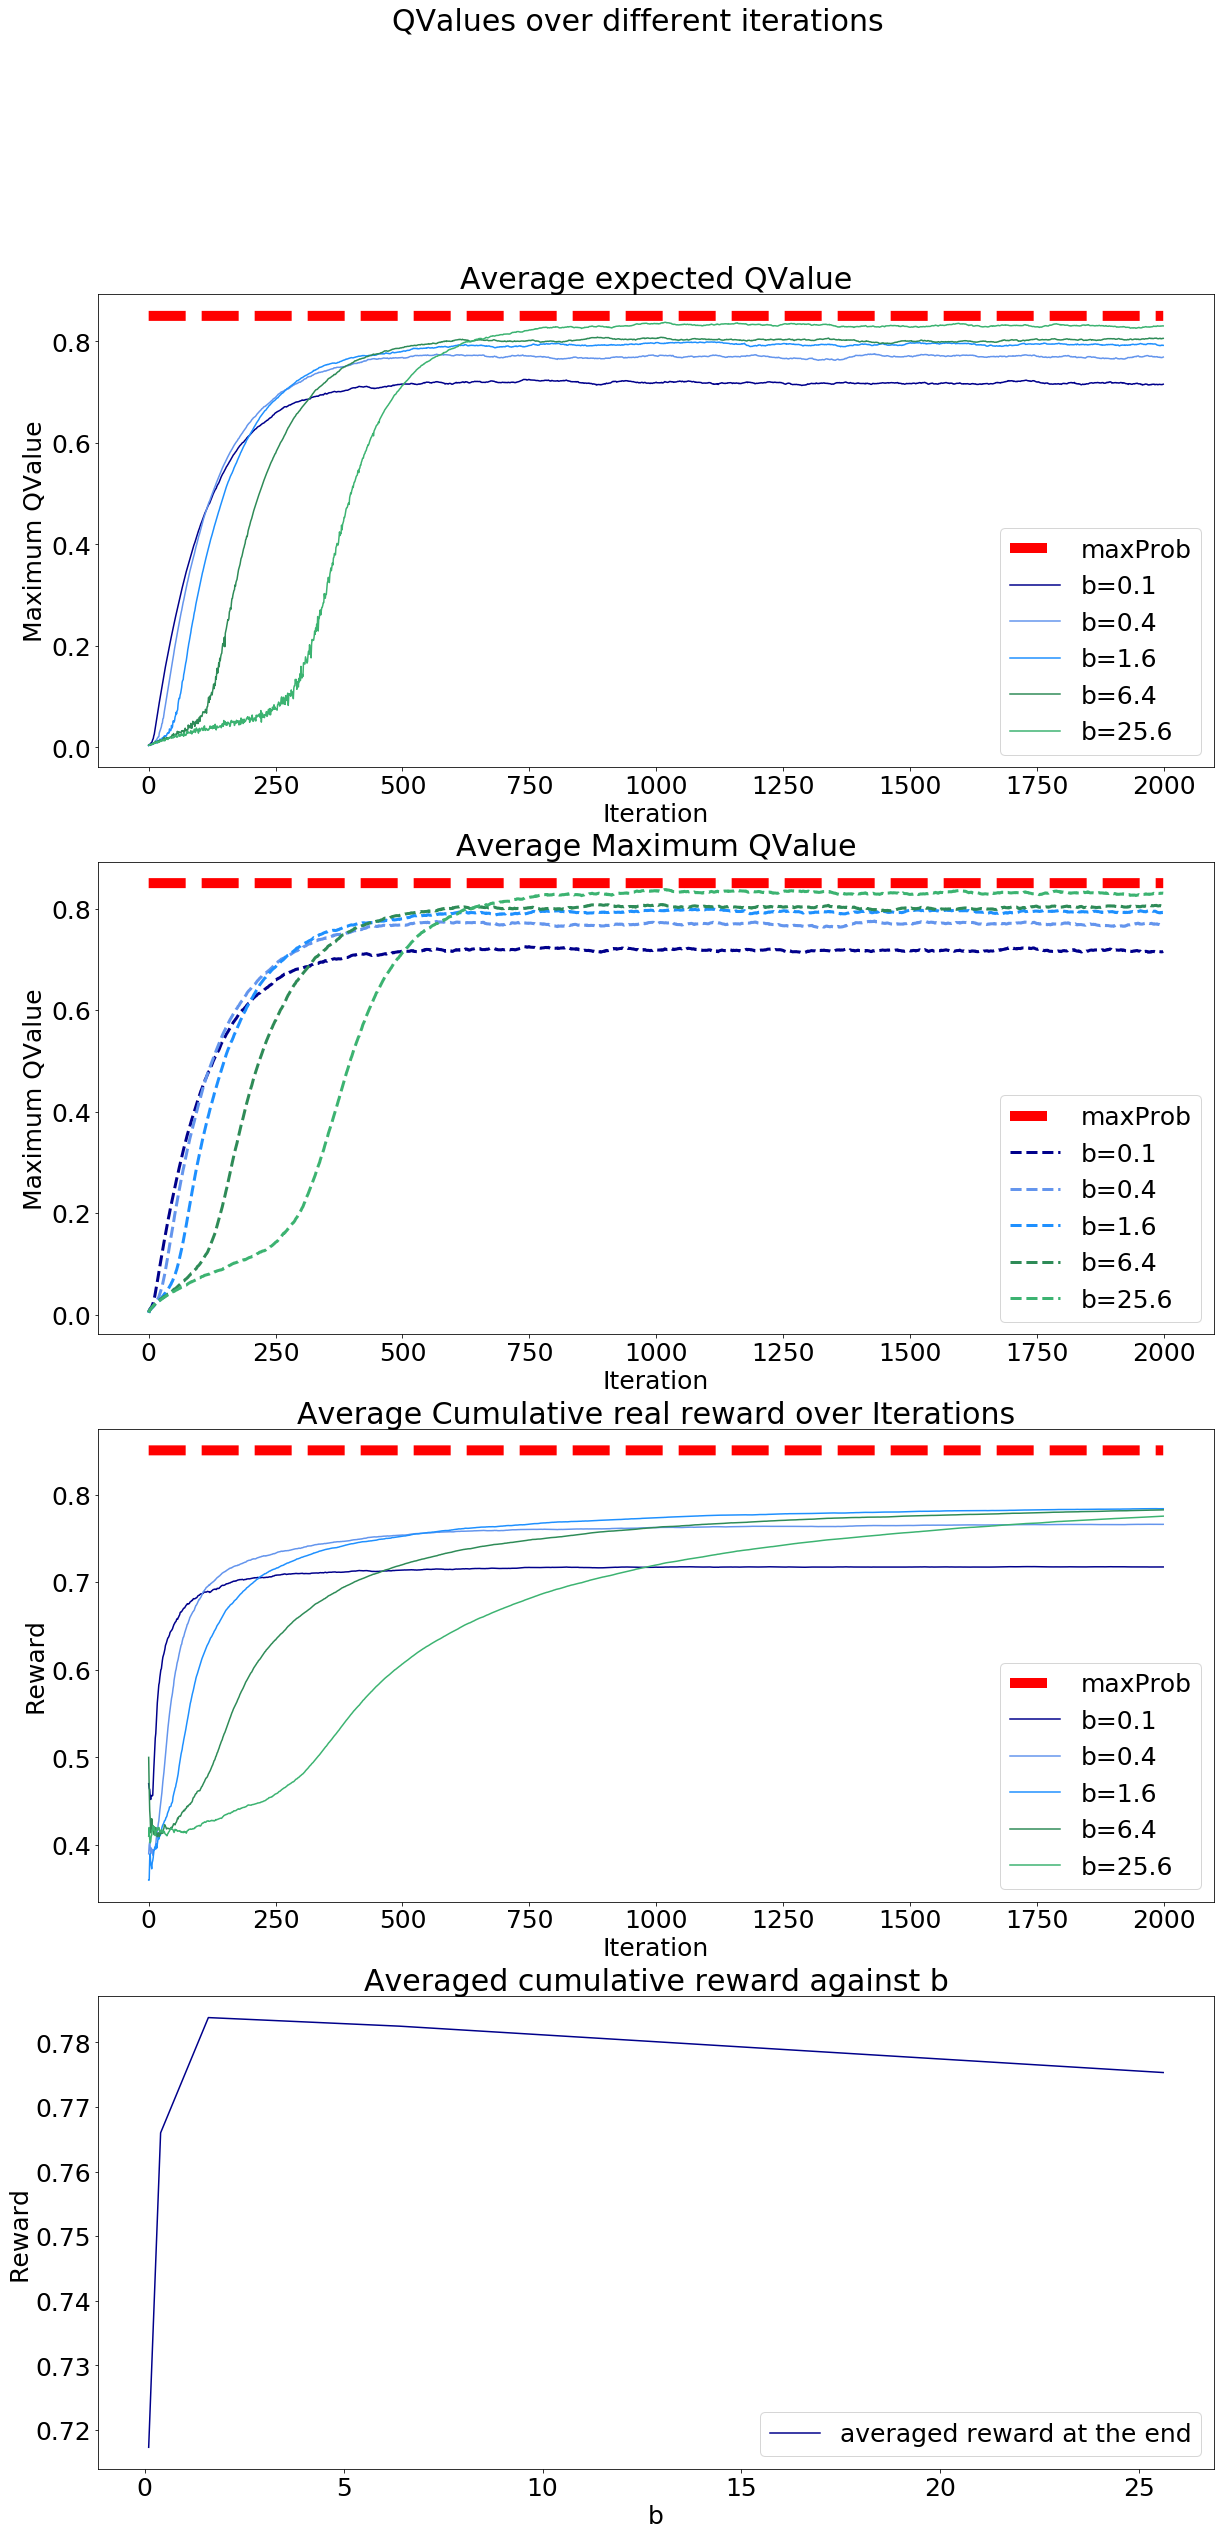

In [9]:
def plot_softmax_mod(lives: int=100, total_pulls: int=2000) -> None:
    
    bs = [.1,.4,1.6,6.4,25.6]
    
    avgs = np.zeros((len(bs), total_pulls))
    avgsMax = np.zeros((len(bs), total_pulls))
    avgsCumSum = np.zeros((len(bs), total_pulls))
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(20,40))
    plt.suptitle('QValues over different iterations')
    
    ax1.set_title('Average expected QValue')
    ax1.set_ylabel('Maximum QValue')
    ax1.set_xlabel('Iteration')
    ax1.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    ax2.set_title('Average Maximum QValue')
    ax2.set_ylabel('Maximum QValue')
    ax2.set_xlabel('Iteration')
    ax2.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    ax3.set_title('Average Cumulative real reward over Iterations')
    ax3.set_ylabel('Reward')
    ax3.set_xlabel('Iteration')
    ax3.plot(np.repeat(nautilus.armProbs.max(), total_pulls), '--r', linewidth=10,\
             label='maxProb')
    
    ax4.set_title(r'Averaged cumulative reward against b')
    ax4.set_ylabel('Reward')
    ax4.set_xlabel('b')
                    
    for bI,b in enumerate(bs):
        
        maxQs = np.zeros((lives, total_pulls))
        leverQs = np.zeros((lives, total_pulls))
        #To store cumulative arm rewards:
        rews = np.zeros((lives, total_pulls))
        
        for life in range(lives):
        
            res = nautilus.softmax(None, total_pulls, beta_mod=True, b=b)
            maxQs[life,:] = res[0]
            leverQs[life,:] = res[1]
            rews[life,:] = res[2]
            #Resetting rewards/qValues to zero:
            nautilus.set_armRewards(np.zeros(nautilus.numArms))
            nautilus.set_qValues(np.zeros(nautilus.numArms))
            
        avgs[bI,:] = leverQs.mean(axis=0)
        avgsMax[bI,:] = maxQs.mean(axis=0)
        avgsCumSum[bI,:] = rews.mean(axis=0)
        #avgsCumSum[bI,:,:] = np.cumsum(rews.mean(axis=0), axis=1)
        ax1.plot(avgs[bI,:], label ='b={}'.format(b))
        ax2.plot(avgsMax[bI,:], '--', linewidth = 3, label='b={}'.format(b))
        ax3.plot(avgsCumSum[bI,:]/np.arange(1,total_pulls+1), label='b={}'.format(b))
         
    ax4.plot(bs, avgsCumSum[:,-1]/total_pulls, label='averaged reward at the end')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()
        
    return None

plot_softmax_mod()

$\textbf{Observation:}$ $b$ acts as a cooldown parameter. It determines how fast the agent trasitions from an exploring to an exploiting agent (we can see a lot of noise in the curves with lower $b$ and the maximum QValue remains low for quite a while). When $b$ is large $\beta$ will remain relatively small for many of the early iterations and, thus, the agent will be lead to explore a lot. Conversely, for small $b$, the agent begins exploiting right away. An $\epsilon$-greedy strategy could mimic this kind of adaptation by lowering $\epsilon$ over time. In the beginning the agent could be allowed to make a lot of random moves (high $\epsilon$). Subsequently, it should be made to exploit its gained knowledge more and more (lower $\epsilon$).

From the plots above it also looks as though explorative agents are better than exploitative ones. This is surprising to us. The general assumption would be that always performing the action with the highest reward probability would prove advantageous in the long run and that this advantage would come to the fore when the agent's performance is averaged out over many lives. The gist seems to be that the explorative agent is better, because in the early stages of the process it gets a much better approximation of the real reward probabilities. Then when we cool down the $\beta$ parameter, it still has ample opportunity to overtake the exploitative agents (look at the green curves in the three topmost plots; it looks as though they come late to the race, but then they can exploit their knowledge much more effectively than agents that were exploitative right from the start).